In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

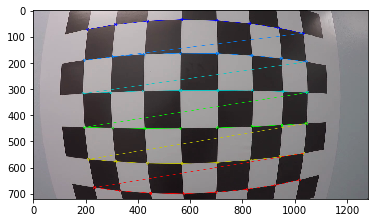

In [2]:
# prepare object points
nx = 8 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = 'input-images/calibration_test.png'
img = cv2.imread(fname)


# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


Note: If you are reading in an image using mpimg.imread() this will read in an RGB image and you should convert to grayscale using cv2.COLOR_RGB2GRAY, but if you are using cv2.imread() or the glob API, as happens in this video example, this will read in a BGR image and you should convert to grayscale using cv2.COLOR_BGR2GRAY. We'll learn more about color conversions later on in this lesson, but please keep this in mind as you write your own code and look at code examples.

# Calibrating Your Camera

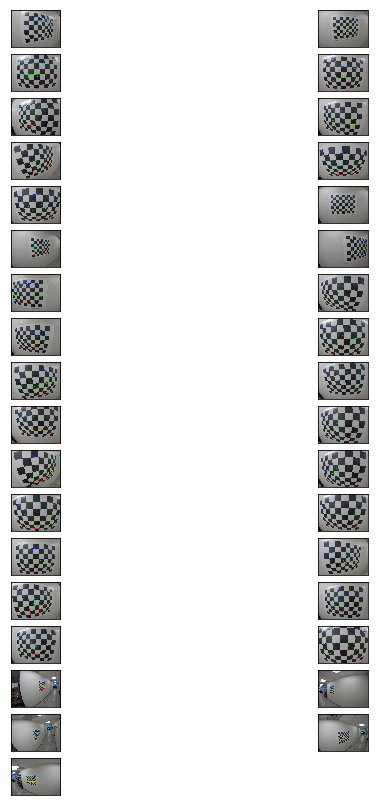

In [3]:
import pickle

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

nx = 8 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane
results = []

# prepare object points, like (0,0,1)
objp = np.zeros ((6*8,3), np.float32)
objp [:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)   
        results.append(img)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        
        
cols = 2
rows = (len(results)+1)//cols
    
plt.figure(figsize=(10, 11))
for i, image in enumerate(results):
    plt.subplot(rows, cols, i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()        
        
dist_pickle = {}
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle1.p", "wb" ) )


**A note on image shape**

The shape of the image, which is passed into the calibrateCamera function, is just the height and width of the image. One way to retrieve these values is by retrieving them from the grayscale image shape array gray.shape[::-1]. This returns the image width and height in pixel values like (1280, 960).

Another way to retrieve the image shape, is to get them directly from the color image by retrieving the first two values in the color image shape array using img.shape[1::-1]. This code snippet asks for just the first two values in the shape array, and reverses them. Note that in our case we are working with a greyscale image, so we only have 2 dimensions (color images have three, height, width, and depth), so this is not necessary.

It's important to use an entire grayscale image shape or the first two values of a color image shape. This is because the entire shape of a color image will include a third value -- the number of color channels -- in addition to the height and width of the image. For example the shape array of a color image might be (960, 1280, 3), which are the pixel height and width of an image (960, 1280) and a third value (3) that represents the three color channels in the color image which you'll learn more about later, and if you try to pass these three values into the calibrateCamera function, you'll get an error.

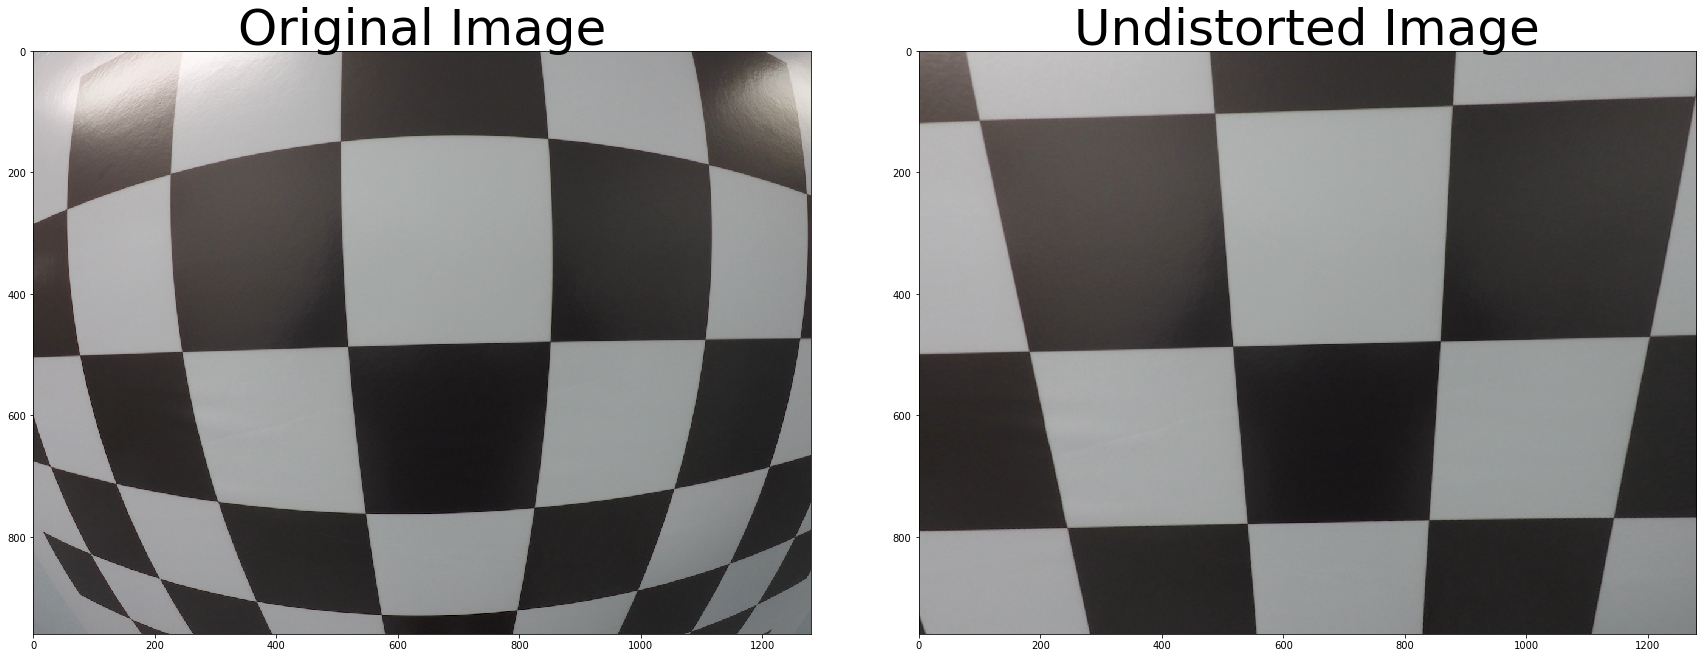

In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle1.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('calibration_wide/test_image.jpg')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "input-images/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('input-images/test_image2.png')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### the gradient threshold and sobel operator

In [ ]:

# You need to pass a single color channel to the cv2.Sobel() function, so first convert it to grayscale:
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Calculate the derivative in the xx direction (the 1, 0 at the end denotes xx direction):
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

# Calculate the derivative in the yy direction (the 0, 1 at the end denotes yy direction):
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

# Calculate the absolute value of the xx derivative:
abs_sobelx = np.absolute(sobelx)

# Convert the absolute value image to 8-bit:
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

"""
Note: It's not entirely necessary to convert to 8-bit (range from 0 to 255) but in practice, it can be useful in the event that you've written a function to apply a particular threshold, and you want it to work the same on input images of different scales, like jpg vs. png. You could just as well choose a different standard range of values, like 0 to 1 etc.
"""

# Create a binary threshold to select pixels based on gradient strength:
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')

"""
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Grayscale
    # Apply cv2.Sobel()
    # Take the absolute value of the output from cv2.Sobel()
    # Scale the result to an 8-bit range (0-255)
    # Apply lower and upper thresholds
    # Create binary_output
    return binary_output
"""

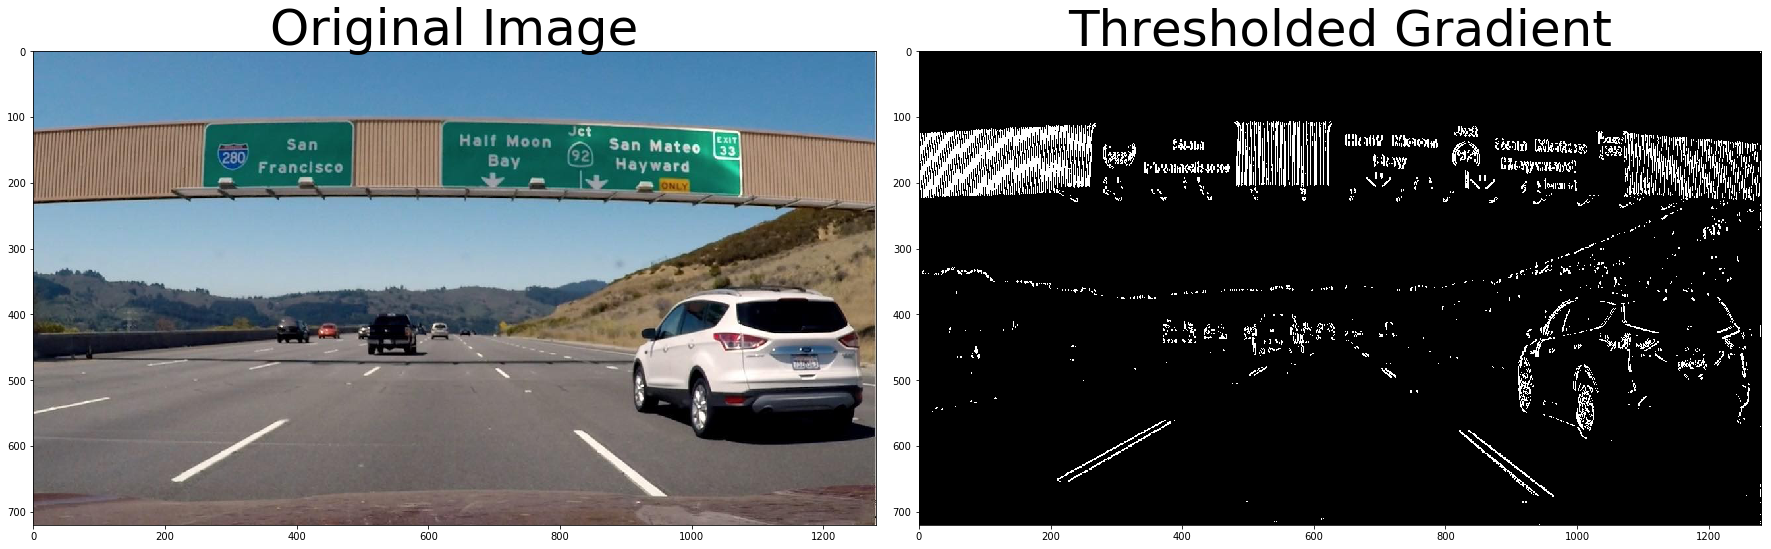

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image and grayscale it
image = mpimg.imread('input-images/signs_vehicles_xygrad.png')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
   

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))


    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

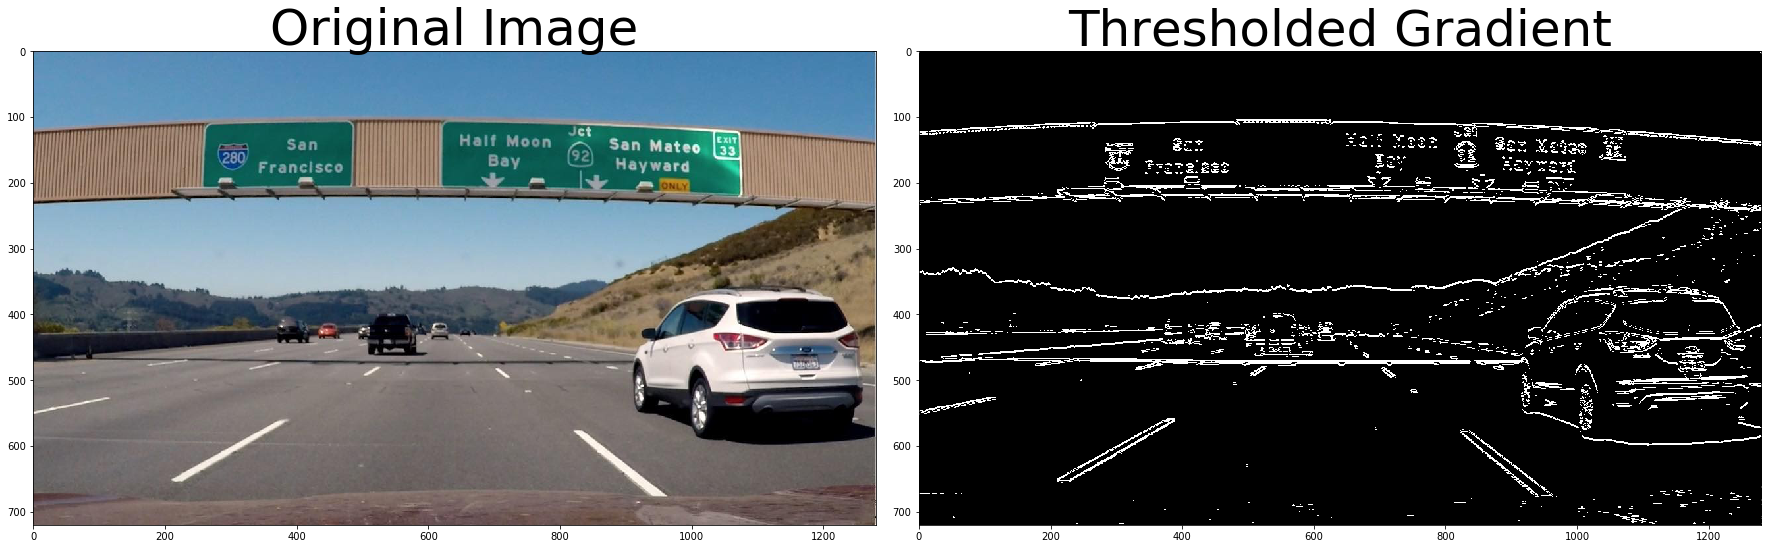

In [4]:
# Run the function
grad_binary = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Magnitude of the Gradient

In this next exercise, your goal is to apply a threshold to the overall magnitude of the gradient, in both x and y.

The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients. For a gradient in both the xx and yy directions, the magnitude is the square root of the sum of the squares.

![alt text](./media/formel1.png)

It's also worth considering the size of the region in the image over which you'll be taking the gradient. You can modify the kernel size for the Sobel operator to change the size of this region. Taking the gradient over larger regions can smooth over noisy intensity fluctuations on small scales. The default Sobel kernel size is 3, but here you'll define a new function that takes kernel size as a parameter.

It's important to note here that the kernel size should be an odd number. Since we are searching for the gradient around a given pixel, we want to have an equal number of pixels in each direction of the region from this central pixel, leading to an odd-numbered filter size - a filter of size three has the central pixel with one additional pixel in each direction, while a filter of size five has an additional two pixels outward from the central pixel in each direction.

The function you'll define for the exercise below should take in an image and optional Sobel kernel size, as well as thresholds for gradient magnitude. Next, you'll compute the gradient magnitude, apply a threshold, and create a binary output image showing where thresholds were met.

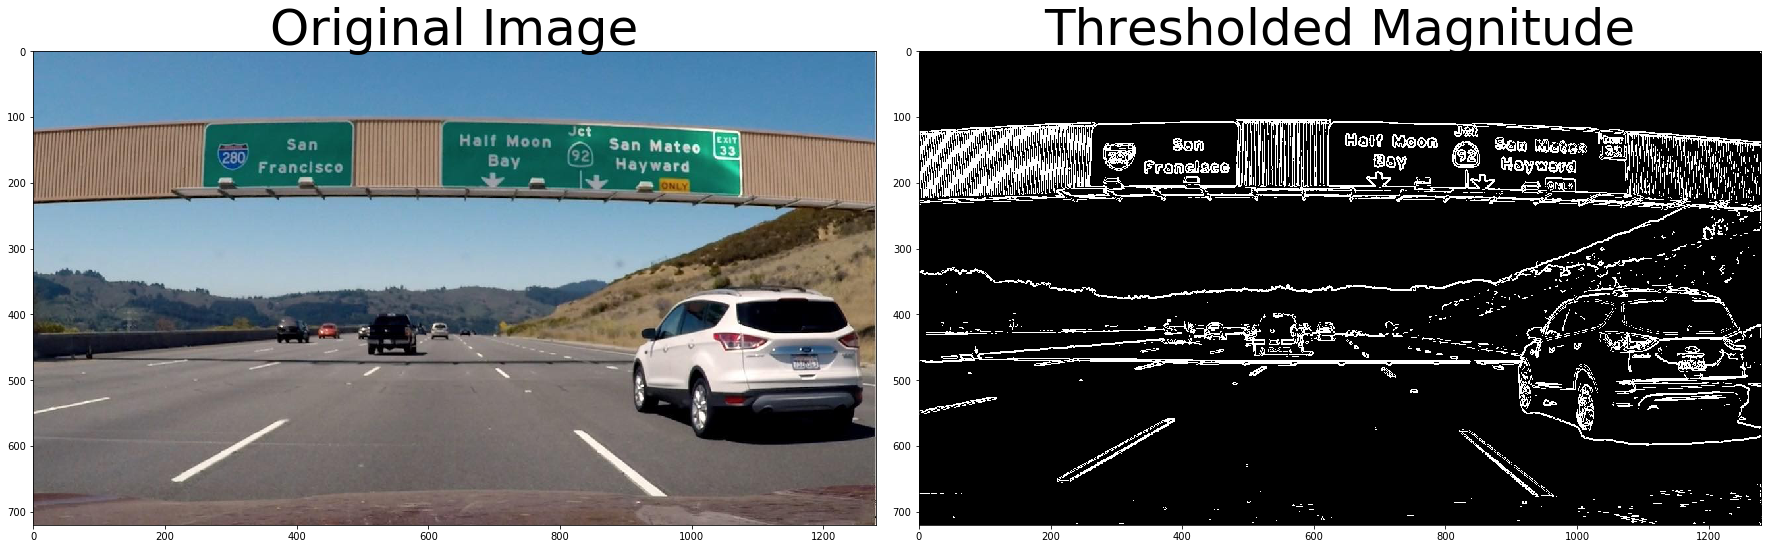

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('input-images/signs_vehicles_xygrad.png')

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

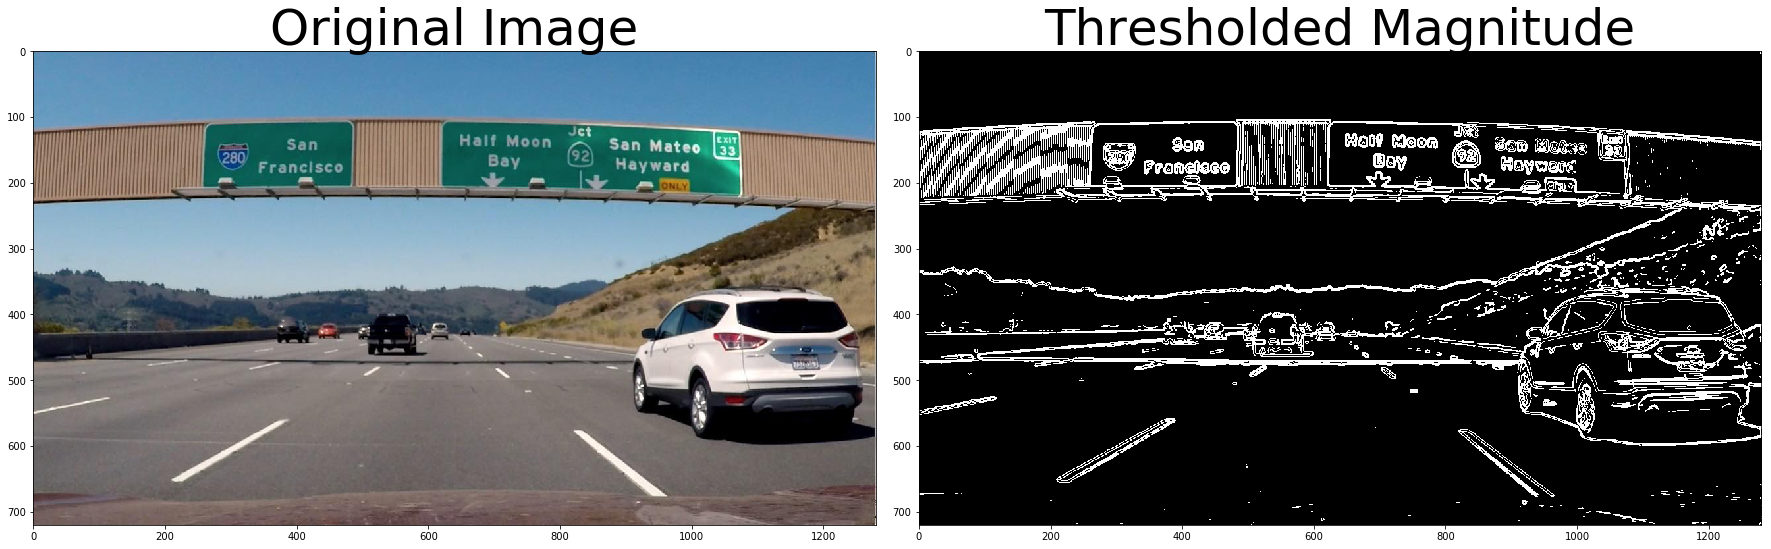

In [13]:
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=7, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Direction of the Gradient

When you play around with the thresholding for the gradient magnitude in the previous exercise, you find what you might expect, namely, that it picks up the lane lines well, but with a lot of other stuff detected too. Gradient magnitude is at the heart of Canny edge detection, and is why Canny works well for picking up all edges.

In the case of lane lines, we're interested only in edges of a particular orientation. So now we will explore the direction, or orientation, of the gradient.

The direction of the gradient is simply the inverse tangent (arctangent) of the yy gradient divided by the xx gradient:

![](./media/text1.png)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    img_cpy = np.copy(img)
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img_cpy, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img_cpy, cv2.CV_64F, 1, 0, ksize=sobel_kernel )
    sobely = cv2.Sobel(img_cpy, cv2.CV_64F, 0, 1, ksize=sobel_kernel )

    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)